In [1]:
from pathlib import Path
import sys

project_root = Path.cwd().parent
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))


In [2]:
from project_dl.dataset import MultiTaskDataset, IMAGENET_MEAN, IMAGENET_STD
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt


/home/pranav/projects/deep-learning-assignment/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset = MultiTaskDataset(project_root, split='train')
val_dataset = MultiTaskDataset(project_root, split='val')

print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')


Train samples: 450
Validation samples: 150


In [4]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

images, class_ids, attr_vectors, metadata = next(iter(train_loader))
print('Images:', images.shape)
print('Class IDs:', class_ids.shape)
print('Attribute vectors:', attr_vectors.shape)
print('Metadata keys:', list(metadata.keys()))


Images: torch.Size([16, 3, 224, 224])
Class IDs: torch.Size([16])
Attribute vectors: torch.Size([16, 20])
Metadata keys: ['caption', 'instance_id', 'class_label', 'image_path']


Class: tableware_waterbottle
Attributes: ['color:blue', 'material:plastic', 'pattern:unknown']
Caption: A blue waterbottle object.
Instance ID: team21_Bottle_6_Blue_Plastic_Plain


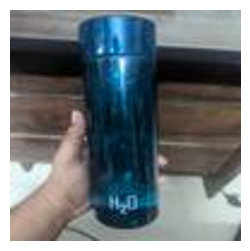

In [5]:
def denormalize(image_tensor):
    mean = torch.tensor(IMAGENET_MEAN, dtype=image_tensor.dtype, device=image_tensor.device).view(-1, 1, 1)
    std = torch.tensor(IMAGENET_STD, dtype=image_tensor.dtype, device=image_tensor.device).view(-1, 1, 1)
    return (image_tensor * std + mean).clamp(0.0, 1.0)

def decode_attributes(attr_vector, dataset):
    indices = attr_vector.nonzero(as_tuple=False).squeeze(-1).tolist() if attr_vector.ndim > 0 else []
    return [dataset.attribute_names()[idx] for idx in indices]

def show_sample(dataset, idx=0):
    image_tensor, class_id, attr_vector, meta = dataset[idx]
    decoded_image = denormalize(image_tensor).permute(1, 2, 0)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(decoded_image)
    ax.axis('off')
    print('Class:', dataset.class_names()[class_id.item()])
    print('Attributes:', decode_attributes(attr_vector, dataset))
    print('Caption:', meta['caption'])
    print('Instance ID:', meta['instance_id'])

# Example usage (run when needed)
show_sample(train_dataset, idx=100)


In [6]:
from project_dl.model import MultiTaskModel

model = MultiTaskModel(
    backbone_name="deit_tiny_patch16_224",
    num_classes=train_dataset.num_classes,
    num_attributes=train_dataset.num_attributes,
    freeze_backbone=True,
)

images, _, _ , _ = next(iter(train_loader))
outputs = model(images)
print('Class logits:', outputs['class_logits'].shape)
print('Attribute logits:', outputs['attr_logits'].shape)
print('Embeddings:', outputs['embedding'].shape)


Class logits: torch.Size([16, 10])
Attribute logits: torch.Size([16, 20])
Embeddings: torch.Size([16, 192])
